##### Experiment 6
* Use word batch

In [1]:
import copy
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os
import re
import threading
import multiprocessing
import gensim
from gensim import corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import string
import unicodedata
import nltk
import wordbatch
from wordbatch.extractors import WordSeq

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, QuantileTransformer
import lightgbm as lgb
from sklearn import metrics
import gc

from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
# from __future__ import print_function
np.random.seed(786)  # for reproducibility

from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,  KerasRegressor
#Some classes
#Functions we need - Feature Selector, Fasttext_Estimator, Preprocessing Transformer, Binary_Encoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.sparse.csr import csr_matrix
from sklearn.metrics import mean_squared_error, make_scorer
from multiprocessing import Pool,cpu_count
from nltk.corpus import stopwords
stopwords = {x: 1 for x in ["a","the","for","of","on"]}
non_alphanums = re.compile(u'[^A-Za-z0-9]+')
def normalize_text(text):
    return u" ".join(
        [x for x in [y for y in non_alphanums.sub(' ', text).lower().strip().split(" ")] \
         if len(x) > 1 and x not in stopwords])

def rmse(y_true, y_pred):
    print(np.min(y_pred), np.max(y_pred))
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse, greater_is_better=False)

def get_obj_cols(df):
    """Return columns with object dtypes"""
    obj_cols = []
    for idx, dt in enumerate(df.dtypes):
        if dt == 'object':
            obj_cols.append(df.columns.values[idx])

    return obj_cols


def convert_input(X):
    """if input not a dataframe convert it to one"""
    if not isinstance(X, pd.DataFrame):
        if isinstance(X, list):
            X = pd.DataFrame(np.array(X))
        elif isinstance(X, (np.generic, np.ndarray)):
            X = pd.DataFrame(X)
        elif isinstance(X, csr_matrix):
            X = pd.SparseDataFrame(X)
        else:
            raise ValueError('Unexpected input type: %s' % (str(type(X))))

        #X = X.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    """ Class to do subset of features in sklearn pipeline"""
    def __init__(self, cols=None, return_df=True, verbose=0):
        self.cols = cols
        self.return_df = return_df
        self.verbose = verbose
        
    def fit(self, X, y=None):
        #Do nothing
        return self
    
    def transform(self, X, y=None):
        #if the input dataset isn't already a dataframe, convert it to one
        X = X.copy(deep=True)
        X = convert_input(X)
        X = X.loc[:, self.col]
        
        if self.verbose:
            print("Selecting columns are {}".format(self.col))
        if self.return_df:
            return X
        else:
            return X.values

        



class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, thresh=0, func=np.mean, add_to_orig=False):
        self.cols = cols
        self.thresh = thresh
        self.func = func
        self.add_to_orig = add_to_orig
    
    #@numba.jit        
    def fit(self, X, y):
        self.prior = self.func(y)
        self._dict = {}
        for col in self.cols:
            if isinstance(col, (list, tuple)):
                print('here')
                tmp_df = X.loc[: ,col]
                col = tuple(col)
            else:
                tmp_df = X.loc[: ,[col]]
            tmp_df['y'] = y
            print(tmp_df.columns)
            #tmp_df = pd.DataFrame({'eval_col':X[col].values, 'y':y})
            if isinstance(col, (list, tuple)):
                print('here')
                col = tuple(col)
            self._dict[col] = tmp_df.groupby(col)['y'].apply(lambda x: 
                                self.func(x) if len(x) >= self.thresh  else self.prior).to_dict()
                                
            del tmp_df
        return self
    #@numba.jit
    def transform(self, X, y=None):
        X_transformed = []
        for col in self.cols:
            
            if isinstance(col, (list, tuple)):
                tmp_df = X.loc[:, col]
                enc = tmp_df[col].apply(lambda x: self._dict[tuple(col)][tuple(x)]
                                                                     if tuple(x) in self._dict[tuple(col)]
                                                                     else self.prior, axis=1).values
            else:
                tmp_df = X.loc[:, [col]]
                enc = tmp_df[col].apply(lambda x: self._dict[col][x]
                                                                     if x in self._dict[col]
                                                                     else self.prior).values
            del tmp_df
            X_transformed.append(enc)
        
        X_transformed = np.vstack(X_transformed).T
        
        if self.add_to_orig:
            return np.concatenate((X.values, X_transformed), axis=1)
            
        else:
            return X_transformed

num_cores=16
num_partitions=32
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def isiphonecase(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                                (series.str.contains('case', flags=re.IGNORECASE)) )
def isiphone6(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('6|six', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone6p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('6|six', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone5(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('5|five', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone5p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('5|five', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone7(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('7|seven', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone7p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('7|seven', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def unicodeToAscii(s):
    return ''.join(
        c if unicodedata.category(c) not in ['So', 'Sm', 'Lo', 'Sc']
        else ' '
        for c in unicodedata.normalize('NFD', str(s))
    )

def remove_puncts(s):
    trans_table = str.maketrans({s:' ' for s in string.punctuation})
    return str(s).translate(trans_table)

#Data reading function
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.)

        
def tokenize(text):
    return text.lower().strip(string.punctuation).split()


def read_data(in_path, out_path):
    if False and os.path.exists(os.path.join(out_path, 'train_2.pkl')) and os.path.exists(os.path.join(out_path, 'test_2.pkl')):
        train_data = pd.read_pickle(os.path.join(out_path, 'train_2.pkl'))
        test_data  = pd.read_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
    
    else:
        train_data = pd.read_table(os.path.join(in_path, 'train.tsv'))
        test_data  = pd.read_table(os.path.join(in_path, 'test.tsv'))
    
        train_rows = len(train_data)
        data = pd.concat([train_data, test_data], ignore_index=True)
    
        data['cat1'] = data['category_name'].apply(lambda x: str(x).split('/')[0])
        data['cat2'] = data['category_name'].apply(lambda x: str(x).split('/')[1] 
                                                   if len(str(x).split('/')) > 1 else -1)
        data['cat3'] = data['category_name'].apply(lambda x: ' '.join(str(x).split('/')[2:]) 
                                                   if len(str(x).split('/')) > 2 else -1)
        data.fillna(-1, inplace=True)
        
        print("Getting word/char len features")
        data['desc_words'] = data['item_description'].apply(lambda x: len(str(x).split()))
        data['desc_chars'] = data['item_description'].apply(lambda x: len(str(x)))
        data['name_words'] = data['name'].apply(lambda x: len(str(x).split()))
        data['name_chars'] = data['name'].apply(len)
        
        
        print("Get iphone features")
        data['iphone_case'] = isiphonecase(data['name'])
        data['iphone6'] = isiphone6(data['name'])
        data['iphone6p'] = isiphone6p(data['name'])
        data['iphone5'] = isiphone5(data['name'])
        data['iphone5p'] = isiphone5p(data['name'])
        data['iphone7'] = isiphone7(data['name'])
        data['iphone7p'] = isiphone7p(data['name'])
        data['unlocked_phone'] = data.name.str.contains('unlocked', flags=re.IGNORECASE)
        cat_cols = ['category_name', 'brand_name', 'cat1', 'cat2', 'cat3', 'item_condition_id']
        for col in cat_cols:
            data[col] = LabelEncoder().fit_transform(data[col].astype(str)) + 1
            
        print("Get count features")
        target_enc1 = TargetEncoder(cols=['brand_name'], func=len)
        data['brand_counts'] = target_enc1.fit_transform(data[['brand_name']], data.price)
        #data['brand_counts'] = data['brand_counts']/data['brand_counts'].max()

        target_enc2 = TargetEncoder(cols=['category_name'], func=len)
        data['cat_counts'] = target_enc2.fit_transform(data[['category_name']], data.price)
        #data['cat_counts'] = data['cat_counts']/data['cat_counts'].max()
        
        target_enc3 = TargetEncoder(cols=['cat1'], func=len)
        data['cat1_counts'] = target_enc3.fit_transform(data[['cat1']], data.price)
        #data['cat1_counts'] = data['cat1_counts']/data['cat1_counts'].max()
        
        target_enc4 = TargetEncoder(cols=['cat2'], func=len)
        data['cat2_counts'] = target_enc4.fit_transform(data[['cat2']], data.price)
        #data['cat2_counts'] = data['cat2_counts']/data['cat2_counts'].max()
        
        target_enc5 = TargetEncoder(cols=['cat3'], func=len)
        data['cat3_counts'] = target_enc5.fit_transform(data[['cat3']], data.price)
        #data['cat3_counts'] = data['cat3_counts']/data['cat3_counts'].max()
        #tkn_desc = Tokenizer(50000)   
        
        #reg = re.compile('[^a-zA-Z0-9 ]')
        data["plus_counts"] = data["name"].apply(lambda x: sum([(s == '+') | (s == '➕') for s in str(x)]))
        data["ands_counts"] = data["name"].apply(lambda x: sum([(s == '&') | (s == ' and ') for s in str(x)]))
        data["comma_counts"] = data["name"].apply(lambda x: sum([s == ',' for s in str(x)]))
        data["all_counts"] = data["plus_counts"] + data["ands_counts"] + data["comma_counts"]
        
        #for col in ["name", "item_description"]:
        #    data[col] = data[col].str.replace("'", '').replace('-', '').progress_apply(unicodeToAscii)
        #    data[col] = data[col].progress_apply(remove_puncts)
        
        
        num_cols =  ["desc_words", "desc_chars", "name_words", "name_chars", "plus_counts", 
                    "ands_counts", "comma_counts", "all_counts", "brand_counts", "cat1_counts", 
                   "cat2_counts", "cat3_counts"]
        data[num_cols]  = QuantileTransformer(output_distribution='normal').fit_transform(data[num_cols])
            
        #data["name_description"] = data["name"] + ' ' + data["item_description"]

        data['item_desc2gram'] = data.item_description.apply(lambda x: add_ngrams(x, 2))
        
        print("Name to sequences")
        wb_name = wordbatch.WordBatch(normalize_text, n_words=20000)
        wb_name.fit(data["name"])
        
        seq_name = WordSeq(wb_name, {"seq_maxlen": 7,  "seq_truncstart":False, "remove_oovs":True})
        seq_name_desc = WordSeq(wb_name, {"seq_maxlen": 20,  "seq_truncstart":False, "remove_oovs":True})
        data["item_name"] = list(zip(seq_name_desc.transform(wb_name.transform(data["item_description"].astype(str)))))
        data["name"] = list(zip(seq_name.transform(wb_name.transform(data["name"].astype(str)))))
        del wb_name, seq_name, seq_name_desc
        
        print("Desc to sequences")
        wb_desc = wordbatch.WordBatch(normalize_text, n_words=50000, extractor=(WordSeq, {"seq_maxlen": 70,
                                                                                          "seq_truncstart":False,
                                                                                          "remove_oovs":True
                                                                            } ))
        #wb_desc.fit(data["item_description"].astype(str))
        data["item_description"] = list(zip(wb_desc.fit_transform(data["item_description"].astype(str))))
        del wb_desc
        
        print("Desc 2gram to sequences")
        wb_desc2 = wordbatch.WordBatch(normalize_text, n_words=20000, extractor=(WordSeq, {"seq_maxlen": 30,
                                                                                           "seq_truncstart":False,
                                                                                           "remove_oovs":True
                                                                            } ))
        #wb_desc2.fit(data["item_desc2gram"].astype(str))
        data["item_desc2gram"] = list(zip(wb_desc2.fit_transform(data["item_desc2gram"].astype(str))))
        del wb_desc2
        
        
        train_data = data.loc[: train_rows - 1, :].reset_index(drop=True)
        train_data = train_data.loc[(train_data.price >= 3) & (train_data.price <= 2000), :].reset_index(drop=True)
        test_data  = data.loc[train_rows: , :].reset_index(drop=True)
        
        del train_data['test_id']
        del test_data['train_id']
        del data 
        test_data['test_id'] = test_data['test_id'].astype(int)
        train_data.to_pickle(os.path.join(out_path, 'train_2.pkl'))
        test_data.to_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
        


/home/mohsin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras.backend as K
from keras.engine.topology import Layer
class ZeroMaskedEntries(Layer):
    """
    This layer is called after an Embedding layer.
    It zeros out all of the masked-out embeddings.
    It also swallows the mask without passing it on.
    You can change this to default pass-on behavior as follows:

    def compute_mask(self, x, mask=None):
        if not self.mask_zero:
            return None
        else:
            return K.not_equal(x, 0)
    """

    def __init__(self, **kwargs):
        self.support_mask = True
        super(ZeroMaskedEntries, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[1]
        self.repeat_dim = input_shape[2]

    def call(self, x, mask=None):
        #print(mask.shape)
        mask = K.cast(mask, 'float32')
        mask = K.repeat(mask, self.repeat_dim)
        #print(mask.shape)
        mask = K.permute_dimensions(mask, (0, 2, 1))
        return x * mask

    def compute_mask(self, input_shape, input_mask=None):
        return None
    
def mask_aware_mean(x):
    # recreate the masks - all zero rows have been masked
    #mask = K.not_equal(K.sum(K.abs(x), axis=2, keepdims=True), 0)

    # number of that rows are not all zeros
    #n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False)
    # compute mask-aware mean of x
    x_mean = K.sum(x, axis=1, keepdims=False)
    #print(x_mean.shape)
    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3 
    return (shape[0], shape[2])

In [64]:
class EM_NNRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, embed_cols=None, dense_cols=None, embed_dims=None, 
                 text_embed_cols=None, text_embed_seq_lens=None, 
                 text_embed_dims=None, 
                 #text_embed_tokenizers=None,
                 num_layers=2, multiprocess=False,
                layer_activations=None, layer_dims=None,layer_dropouts=None, epochs=20, batchsize=32,
                optimizer_kwargs=None, val_size=0.1, verbose=1, seed=1,):
        
        self.embed_cols = embed_cols
        self.dense_cols = dense_cols
        self.embed_dims = embed_dims
        self.text_embed_cols = text_embed_cols
        self.text_embed_dims = text_embed_dims
        #self.text_embed_tokenizers = text_embed_tokenizers
        self.text_embed_seq_lens = text_embed_seq_lens
        self.dense_dims = None
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.layer_dropouts = layer_dropouts
        self.epochs = epochs
        self.batchsize = batchsize
        self.optimizer_kwargs = optimizer_kwargs
        self.val_size = val_size
        self.verbose = verbose
        self.multiprocess = multiprocess
        self.seed = seed
        #self.optim = optim
        self.model = None
        if self.dense_cols:
            self.dense_dims = len(self.dense_cols)
            
    def _splitX(self, X):
        X_splits = []
        
        if self.embed_cols:
            for col in self.embed_cols :
                X_splits.append(X[col].values.reshape(X.shape[0], -1))
                
        if self.text_embed_cols:
            for i, col in enumerate(self.text_embed_cols):
                #max_features = self.text_embed_dims[i][0]
                #max_len = self.text_embed_seq_lens[i]
                #input_text = X[col].astype(str)
                #x_train = tok.texts_to_sequences(input_text)
                #print(np.mean([len(l) for l in x_train]))
                #x_train = sequence.pad_sequences(x_train, maxlen=max_len)
                #X_splits.append(np.array(x_train).reshape(X.shape[0], -1))
                X_splits.append(np.concatenate(X[col].values))
                
        if self.dense_cols:
            X_splits.append(X[self.dense_cols].values.reshape(X.shape[0], -1))
            
        #X_splits.append(X[self.dense_cols].values.reshape(X.shape[0], -1))
        return X_splits
    
    
    def _build_model(self):
        model_inputs = []
        model_layers = []
        
        if self.embed_cols:
            for col, dim in zip(self.embed_cols, self.embed_dims):
                x1 = Input( shape=(1,), name=col)
                model_inputs.append(x1)
                x1 = Embedding(input_dim=dim[0], output_dim=dim[1], )(x1)
                #x1 = Dropout(0.1)(x1)
                x1 = Reshape(target_shape=(dim[1],))(x1)
                model_layers.append(x1)
                
        if self.text_embed_cols:
            for col, dim, seq_len in zip(self.text_embed_cols, 
                                                self.text_embed_dims, 
                                                self.text_embed_seq_lens):
                x3 = Input( shape=(seq_len,))
                model_inputs.append(x3)
                x3 = Embedding(input_dim=dim[0], output_dim=dim[1], input_length=seq_len,
                           )(x3)
                #x3 = Permute((2,1))(x3)
                #x3 = BatchNormalization()(x3)
                #x3 = Dense(1)(x3)
                #attention_probs = Dense(seq_len, activation='softmax')(x3)
                
                #x3 = merge([x3, attention_probs], output_shape=dim[1], mode='mul')
                #print(x3.shape)
                #x3 = Permute((2,1))(x3)
                #x3 = GRU(dim[1])(x3)
                x3 = GlobalAveragePooling1D()(x3)
                #print(x3.shape)
                #x3 = GlobalAvgPool1D()(x3)
                #x3 = Reshape(target_shape=(dim[1],))(x3)
                #x3 = Flatten()(x3)
                #x3 = ZeroMaskedEntries()(x3)
                #x3 = Lambda(mask_aware_mean, mask_aware_mean_output_shape)(x3)
                model_layers.append(x3)
                
        if self.dense_cols:
            x2 = Input( shape=(self.dense_dims, ), name='dense_cols')
            model_inputs.append(x2)
            model_layers.append(x2)
        print(model_layers)
        x = concatenate(model_layers)
        
        if self.num_layers > 0:
            for dim, drops in zip(self.layer_dims, self.layer_dropouts):
                x = BatchNormalization()(x)
                x = Dropout(rate=drops)(x)
                x = Dense(dim, activation='selu',kernel_initializer='he_normal')(x)
                #x = PReLU()(x)
        
        #if self.dense_cols:
        #    x2 = Input( shape=(self.dense_dims, ), name='dense_cols2')
        #    model_inputs.append(x2)
        #    x = concatenate([x, x2])
        #    x = BatchNormalization()(x)
        #    x = Dropout(0.05)(x)
        #    x = Dense(100, activation='selu', kernel_initializer='he_normal')(x)
        #x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.03)(x)
        output = Dense(1,  kernel_initializer='he_normal')(x)
        
        model = Model(inputs=model_inputs, outputs=output)
        #print(model.summary())
        #adam = Nadam(clipvalue=10)
        #adam = Adam(lr=0.001)
        #adam = SGD(lr=0.01, nesterov=True, momentum=0.9, decay=0.003)
        adam = RMSprop(lr=0.009, decay=0.006, clipvalue=2.5)
        #adam = self.optim
        model.compile(optimizer=adam, loss='mean_squared_error' )
        print(model.summary())
        return model 
    
    
    def fit(self, X, y):
        self.model = self._build_model()
        if self.val_size > 0:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=self.seed)
            print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
            
            callbacks= [ModelCheckpoint("embed_NN_"+str(self.seed)+".check", save_best_only=True, verbose=1)]
            if self.multiprocess == False:
                self.model.fit(self._splitX(X_train), y_train, batch_size=self.batchsize, epochs=self.epochs,
                               verbose=self.verbose,
                              validation_data=(self._splitX(X_val), y_val), shuffle=True,
                              callbacks=callbacks)
            else:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=1)

        else:
            self.model.fit(self._splitX(X), y, batch_size=self.batchsize, epochs=self.epochs,
               verbose=self.verbose, shuffle=True)

        
        return self
    
    def predict(self, X, y=None):
        
        if self.model:
            model = load_model("embed_NN_"+str(self.seed)+".check")
            y_hat = model.predict(self._splitX(X))
        else:
            raise ValueError("Model not fit yet")
            
        return y_hat
        
def add_ngrams(text, ngram=2):
    word_list = str(text).lower().split(' ')
    out_list = [''.join(word_list[i:i+ngram]) for i in range(len(word_list))]
    return ' '.join(out_list[:-1])
        



In [4]:
data = pd.read_table("../input/train.tsv")
wb_name = wordbatch.WordBatch(normalize_text, n_words=20000)
wb_name.fit(data["name"])

Normalize text


In [5]:
#wb_name.dictionary_freeze=True

In [6]:
#wb_name.extractor#

In [7]:
seq_name = WordSeq(wb_name, {"seq_maxlen": 20,  "seq_truncstart":False, "remove_oovs":True})
seq_name.transform(data["item_description"].astype(str).values)

Extract wordseqs


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1583, 13439],
 [1515,
  930,
  71,
  778,
  903,
  8,
  226,
  231,
  207,
  13016,
  451,
  10791,
  2119,
  5856,
  8,
  1036,
  916,
  2119,
  9579,
  8464],
 [0,
  0,
  0,
  0,
  0,
  18,
  60,
  69,
  8,
  597,
  4730,
  71,
  3162,
  1,
  930,
  8,
  9680,
  3461,
  3688,
  71],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  60,
  2803,
  1793,
  2119,
  8357,
  999,
  1494,
  14269,
  1393,
  3392,
  451,
  1332],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 17933],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 772, 102, 60, 1402, 563, 8, 1455],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  33,
  2987,
  2965,
  7922,
  262,
  139,
  277,
  903],
 [1968,
  964,
  222,
  1975,
  21,
  4,
  33,
  8,
  47,
  61,
  8,
  194,
  140,
  21,
  1059,
  1402,
  697,
  71,
  33,
  8],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 21],
 [2808,
  48,
  2119,
  2459,
  10542,
  614,
  3300,
  1045,
  49

In [8]:
#wb_name.transform(data["item_description"].astype(str).values, extractor=(WordSeq,  {"seq_maxlen": 7,"seq_truncstart":False}))

In [9]:
#Read data
train_data, test_data = read_data("../input", "./")
print(train_data.shape, test_data.shape)
train_data.head()

Getting word/char len features
Get iphone features
Get count features
Index(['brand_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['cat1', 'y'], dtype='object')
Index(['cat2', 'y'], dtype='object')
Index(['cat3', 'y'], dtype='object')
Name to sequences
Normalize text
Normalize text
Extract wordseqs
Normalize text
Extract wordseqs
Desc to sequences
Normalize text
Extract wordseqs
Desc 2gram to sequences
Normalize text
Extract wordseqs
(1481658, 34) (693359, 34)


,brand_name,category_name,item_condition_id,item_description,name,price,shipping,train_id,cat1,cat2,...,cat_counts,cat1_counts,cat2_counts,cat3_counts,plus_counts,ands_counts,comma_counts,all_counts,item_desc2gram,item_name
0,3,831,3,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 2601, 4662, 5010, 14, 4, 45],)",10.0,1,0.0,6,104,...,22251,-0.914679,-0.502074,0.188033,-5.199338,-5.199338,-5.199338,-5.199338,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,3891,88,3,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 0, 0, 5691, 12710, 10090, 1526],)",52.0,0,1.0,2,32,...,1419,-0.665852,-1.321946,-1.467860,-5.199338,-5.199338,-5.199338,-5.199338,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 64, 17, 685,...","([1055, 1526, 936, 70, 790, 920, 8, 224, 230, ..."
2,4590,1279,1,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 0, 0, 0, 3792, 6022, 179],)",10.0,1,2.0,10,105,...,29812,5.199338,0.805692,0.512061,-5.199338,-5.199338,-5.199338,-5.199338,"([0, 0, 0, 0, 0, 0, 0, 1215, 62, 11276, 8938, ...","([1321, 18, 59, 67, 8, 609, 4612, 70, 281, 337..."
3,3,505,1,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 0, 0, 0, 100, 1565, 11354],)",35.0,1,3.0,4,57,...,19146,-1.144896,-0.369558,0.013801,-5.199338,-5.199338,-5.199338,-5.199338,"([21, 37, 29, 526, 145, 1760, 4, 4, 164, 164, ...","([3, 59, 738, 100, 5125, 2540, 119, 2088, 932,..."
4,3,1206,1,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 0, 0, 3472, 37, 880, 120],)",44.0,0,4.0,10,60,...,28926,5.199338,0.426601,0.399276,-5.199338,-5.199338,-5.199338,-5.199338,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
print("Get target encodings for stuff")
cvlist = list(KFold(6, random_state=100).split(train_data))

enc_1 = TargetEncoder(cols=['brand_name'])
train_data["brand_mean"] = cross_val_predict(enc_1, train_data[['brand_name']], train_data['price'], cv=cvlist, verbose=10, method='transform', n_jobs=-1)
test_data["brand_mean"] = enc_1.fit(train_data[['brand_name']], train_data['price']).transform(test_data)


enc_2 = TargetEncoder(cols=['category_name'])
train_data["category_mean"] = cross_val_predict(enc_2, train_data[['category_name']], train_data['price'], cv=cvlist, verbose=10, method='transform', n_jobs=-1)
test_data["category_mean"] = enc_2.fit(train_data[['category_name']], train_data['price']).transform(test_data)

enc_3 = TargetEncoder(cols=[['brand_name', 'category_name']])
train_data["brandcat_mean"] = cross_val_predict(enc_3, train_data[['brand_name', 'category_name']], train_data['price'], cv=cvlist, verbose=10, method='transform', n_jobs=-1)
test_data["brandcat_mean"] = enc_3.fit(train_data[['brand_name', 'category_name']], train_data['price']).transform(test_data)

train_data["brandcat_rat"] = train_data["brandcat_mean"]/(1 + train_data["category_mean"])
test_data["brandcat_rat"] = test_data["brandcat_mean"]/(1 + test_data["category_mean"])

train_data["catbrand_rat"] = train_data["brandcat_mean"]/(1 + train_data["category_mean"])
test_data["catbrand_rat"] = test_data["brandcat_mean"]/(1 + test_data["brand_mean"])

enc_4 = TargetEncoder(cols=['brand_name'])
train_data["brandvalue"] = cross_val_predict(enc_4, train_data[['brand_name']], train_data["brandcat_rat"], cv=cvlist, verbose=10, method='transform', n_jobs=-1)
test_data["brandvalue"] = enc_4.fit(train_data[['brand_name']], train_data["brandcat_rat"]).transform(test_data)


Get target encodings for stuff
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s finished


Index(['brand_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.8s finished


Index(['category_name', 'y'], dtype='object')
here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here
here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here
here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here
here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here
here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here
here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   11.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   11.0s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   11.1s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.4s finished


here
Index(['brand_name', 'category_name', 'y'], dtype='object')
here
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')
Index(['brand_name', 'y'], dtype='object')


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s finished


Index(['brand_name', 'y'], dtype='object')


In [11]:
feats2 = ["brandvalue", "catbrand_rat", "brandcat_rat", "category_mean", "brand_mean"]
scaler = QuantileTransformer(output_distribution='normal')
train_data[feats2] = scaler.fit_transform(train_data[feats2])
test_data[feats2] = scaler.transform(test_data[feats2])

In [10]:
X = train_data
y = np.log1p(train_data.price)

cvlist= list(KFold(5, random_state=786).split(X, y))

In [62]:
nnet1 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 50),(1500, 40), (6,8), (16,6), (121, 20), (900, 30)],
                  text_embed_cols=['name', 'item_description', 
                                   'item_desc2gram', 
                                   'item_name'
                                  ],
                  text_embed_dims=[(20000, 50), (50000, 50), 
                                   (20000, 30), 
                                   (20000, 30)
                                  ],
                  text_embed_seq_lens =[7, 70, 
                                       30,
                                        20
                                       ],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars','name_words',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts',
                              "plus_counts", "comma_counts", "ands_counts", 'all_counts',
                              #"brandvalue", "catbrand_rat", "brandcat_rat", "category_mean", "brand_mean"
                                  ],
                  epochs=10,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.12],
                  layer_dims=[250],
                  seed=1,
                  val_size=0.02,
                 )

In [21]:
oof_preds1 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds1)
print(score)

[<tf.Tensor 'reshape_31/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_32/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_33/Reshape:0' shape=(?, 8) dtype=float32>, <tf.Tensor 'reshape_34/Reshape:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'reshape_35/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_36/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_37/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_38/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_39/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_40/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_3:0' shape=(?, 22) dtype=float32>]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 7)            0                                            
______

(1161619, 34) (23707, 34) (1161619,) (23707,)


KeyboardInterrupt: 

In [31]:
import gc
gc.collect()

44338

In [20]:
nnet1.model.summary()

AttributeError: 'NoneType' object has no attribute 'summary'

In [ ]:
nnet2 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 30),(1500, 25), (5,4), (15,4), (120, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 'item_desc2gram'],
                  text_embed_dims=[(20000, 30), (100000, 30), (10000, 30), (20000, 30)],
                  text_embed_seq_lens =[7, 80, 20, 20],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                  epochs=6,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.1],
                  layer_dims=[100],
                  seed=2,
                  val_size=0.02
                 )


In [ ]:
oof_preds2 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds2)
print(score)

In [ ]:
nnet3 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 30),(1500, 20), (5,4), (15,4), (120, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 'item_desc2gram'],
                  text_embed_dims=[(20000, 50), (50000, 50), (20000, 50)],
                  text_embed_seq_lens =[7, 70, 30],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                  epochs=4,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.25],
                  layer_dims=[200],
                  seed=3,
                  val_size=0.02,
                 )
oof_preds3 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds3)
print(score)

In [ ]:
from scipy.stats import hmean, gmean

In [ ]:
oof_preds = np.mean(np.hstack((oof_preds1, oof_preds2, oof_preds3)), axis=1)
print(oof_preds.shape)
rmse(y, oof_preds)


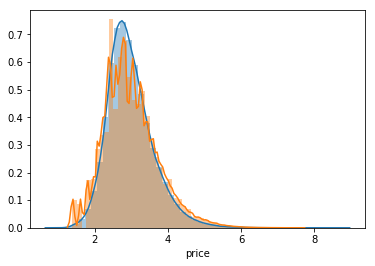

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(oof_preds)
sns.distplot(y)
plt.show()

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1, min_samples_leaf=50)
oof_X = np.hstack((oof_preds1, oof_preds2, oof_preds3))
print(oof_X.shape)
oof2 = cross_val_predict(rfr, oof_X, y , cv=5, verbose=10)
rmse(y, oof2)

(1481658, 3)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.3s remaining:    0.0s


1.988219376342803 4.961022181829234


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s finished


0.4244249992307715

In [11]:
#adding GRU - worsened performance
#Flatten - worse

In [63]:
nnet1.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
#test_preds1 = nnet1.predict(test_data)

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


(?, 50, 7)
(?, 50, 70)
(?, 30, 30)
(?, 30, 20)
[<tf.Tensor 'reshape_125/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_126/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_127/Reshape:0' shape=(?, 8) dtype=float32>, <tf.Tensor 'reshape_128/Reshape:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'reshape_129/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_130/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'global_average_pooling1d_29/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_30/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_31/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'global_average_pooling1d_32/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_12:0' shape=(?, 22) dtype=float32>]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                 

__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 336)          0           reshape_125[0][0]                
                                                                 reshape_126[0][0]                
                                                                 reshape_127[0][0]                
                                                                 reshape_128[0][0]                
                                                                 reshape_129[0][0]                
                                                                 reshape_130[0][0]                
                                                                 global_average_pooling1d_29[0][0]
                                                                 global_average_pooling1d_30[0][0]
                                                                 global_average_pooling1d_31[0][0]
          

In [17]:
nnet2.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds2 = nnet2.predict(test_data)

[<tf.Tensor 'reshape_55/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_56/Reshape:0' shape=(?, 25) dtype=float32>, <tf.Tensor 'reshape_57/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_58/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_59/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_60/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_61/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_62/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_63/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_11:0' shape=(?, 17) dtype=float32>]
(1452024, 32) (29634, 32) (1452024,) (29634,)
Train on 1452024 samples, validate on 29634 samples
Epoch 1/6
1452024/1452024 [==============================] - 18s 12us/step - loss: 0.4859 - val_loss: 0.2130
Epoch 2/6
1452024/1452024 [==============================] - 15s 10us/step - loss: 0.2104 - val_loss: 0.1876
Epoch 3/6
1452024/1452024 [=======================

In [12]:
nnet3.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds3 = nnet3.predict(test_data)

test_preds = (1/3)*(test_preds1 + test_preds2 + test_preds3)
print("Write out submission")
submission: pd.DataFrame = test_data[['test_id']]
submission['price'] = np.expm1(test_preds)
submission.price = submission.price.clip(3, 2000)
submission.to_csv("embedding_nn_v2.csv", index=False)

[<tf.Tensor 'reshape_136/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_137/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_138/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_139/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_140/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_141/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_142/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_143/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_144/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_30:0' shape=(?, 21) dtype=float32>]
(1444616, 32) (37042, 32) (1444616,) (37042,)
Train on 1444616 samples, validate on 37042 samples
Epoch 1/5
1444616/1444616 [==============================] - 24s 17us/step - loss: 0.5103 - val_loss: 0.2013
Epoch 2/5
1444616/1444616 [==============================] - 18s 12us/step - loss: 0.1956 - val_loss: 0.1780
Epoch 3/5
1444616/1444616 [==============

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
